## Bangkit Final Project: Aksara Jawa Classification with Machine Learning

## Dependencies


In [0]:
# Install dependencies

!pip install -q kaggle
!pip install keras==2.3.0

     |████████████████████████████████| 378kB 8.6MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [1]:
import keras,os
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Colab library to upload files to notebook
from google.colab import files

Using TensorFlow backend.


In [2]:
# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

## Data Preparation


In [0]:
%%time
# Download dataset from upstream
!kaggle datasets download -d phiard/aksara-jawa

In [0]:
%%time
# Unzip dataset into a folder
!unzip aksara-jawa.zip -d dataset

In [6]:
# Do the image augmentation and rescale image
train_datagen = ImageDataGenerator(
      rescale=1./255,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    directory="/content/dataset/newdatasetaug/newtraining",
    target_size=(224,224),
    batch_size=20)

validation_data = validation_datagen.flow_from_directory(
    directory="/content/dataset/newdatasetaug/newtesting",
    target_size=(224,224),
    batch_size=20)

Found 1441 images belonging to 20 classes.
Found 839 images belonging to 20 classes.


## Build the Model



In [0]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam


In [13]:
model = Sequential()

model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=20, activation="softmax"))

opt = Adam(lr=0.000001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

model.summary()

checkpoint = ModelCheckpoint("dummy_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
hist = model.fit_generator(steps_per_epoch=50,generator=train_data, validation_data= validation_data, validation_steps=5,epochs=50,callbacks=[checkpoint,early])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 56, 56, 256)      

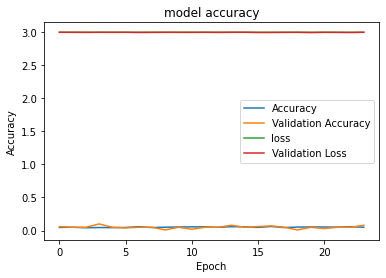

In [12]:
import matplotlib.pyplot as plt

plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

## Save model to json

In [0]:
!pip install h5py

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("model_dummy.json", "w") as json_file:
    json_file.write(model_json)